In [2]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats
import itertools
import pickle
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from community import community_louvain as louvain
import networkx.algorithms.community as nx_comm
from node2vec import Node2Vec
import community

In [4]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload() # upload your kaggle api key

In [6]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d irkaal/foodcom-recipes-and-reviews

 99% 718M/723M [00:10<00:00, 36.8MB/s]
100% 723M/723M [00:10<00:00, 72.1MB/s]


In [9]:
!unzip -q ./foodcom-recipes-and-reviews.zip -d .

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
recipes = pd.read_csv('/content/recipes.csv')

In [12]:
reviews = pd.read_csv('/content/reviews.csv')


In [ ]:
reviews

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z
...,...,...,...,...,...,...,...,...
1401977,2090339,139499,2002080368,terrylbiggs,2,I was disappointed. I couldn't wait to make th...,2020-12-27T23:57:54Z,2020-12-27T23:57:54Z
1401978,2090340,148484,41805321,rogerberry,5,Nothing to drain. And I don’t heat up the liqu...,2020-12-28T00:44:42Z,2020-12-28T00:44:42Z
1401979,2090341,264191,2002901848,Reiketsukan 6.,5,Good base recipe for someone to start with. I ...,2020-12-28T01:04:43Z,2020-12-28T01:04:43Z
1401980,2090345,411791,2002901938,Sue M.,5,Thank you so much for this amazing recipe! I l...,2020-12-28T03:07:10Z,2020-12-28T03:07:10Z


In [ ]:
recipes

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522512,541379,Meg's Fresh Ginger Gingerbread,2002090414,rdsxc,PT35M,PT1H,PT1H35M,2020-12-22T15:27:00Z,Make and share this Meg's Fresh Ginger Gingerb...,character(0),...,7.6,54.4,278.2,48.5,0.8,22.8,3.9,8.0,1 8x8 cake pan,"c(""Preheat oven to 350&deg;F Grease an 8x8 cak..."
522513,541380,Roast Prime Rib au Poivre with Mixed Peppercorns,211566,Denver cooks,PT3H,PT30M,PT3H30M,2020-12-22T15:32:00Z,"White, black, green, and pink peppercorns add ...","""https://img.sndimg.com/food/image/upload/w_55...",...,71.4,433.8,766.3,3.2,0.7,0.1,117.0,8.0,1 Roast,"c(""Position rack in center of oven and preheat..."
522514,541381,Kirshwasser Ice Cream,2001131545,Jonathan F.,PT3H,PT1H,PT4H,2020-12-22T15:33:00Z,Make and share this Kirshwasser Ice Cream reci...,character(0),...,72.6,470.9,192.5,33.9,0.0,17.3,12.8,6.0,NaN,"c(""heat half and half and heavy cream to a sim..."
522515,541382,Quick & Easy Asian Cucumber Salmon Rolls,2001004241,CLUBFOODY,NaN,PT15M,PT15M,2020-12-22T22:11:00Z,"Extremely quick and easy to make, these are gr...","""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,2.9,100.5,0.3,0.0,0.1,2.4,NaN,20 rolls,"c(""In a small bowl, combine mayo and wasabi pa..."


We want to merge the two datasets on the RecipeId.

In [13]:
food_data = pd.merge(recipes, reviews, on = 'RecipeId')
food_data

,RecipeId,Name,AuthorId_x,AuthorName_x,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,RecipeServings,RecipeYield,RecipeInstructions,ReviewId,AuthorId_y,AuthorName_y,Rating,Review,DateSubmitted,DateModified
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan...",579149,596506,allisonsmommy,5,"Yummy, yummy, yummy! I am a big fan of fruit a...",2008-02-13T00:26:49Z,2008-02-13T00:26:49Z
1,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan...",789264,1060485,allyop135,4,very good!! the directions were alittle weird ...,2009-01-15T20:02:30Z,2009-01-15T20:02:30Z
2,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan...",1448544,1802956262,ionnym,4,This does taste great! I think the recipe need...,2014-07-22T21:23:02Z,2014-07-22T21:23:02Z
3,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan...",1450744,2123645,DeliciousAsItLooks,4,Tasty and refreshing! I love the creamy flavor...,2014-08-14T20:51:35Z,2014-08-14T20:51:35Z
4,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and...",361851,393254,cassiopeia94,3,I have an Indian friend who made this dish for...,2007-01-20T14:00:09Z,2007-01-20T14:00:09Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401958,540899,Butter Pecan Banana Muffins,1827868,jarp4,PT18M,PT10M,PT28M,2020-09-01T20:59:00Z,Make and share this Butter Pecan Banana Muffin...,character(0),...,12.0,12 Muffins,"c(""Heat oven to 375 degrees. Coat a standard 1...",2087065,2002811014,Rick J.,5,We had these for breakfast this morning. They ...,2020-09-03T17:55:43Z,2020-09-03T17:55:43Z
1401959,541001,Homemade Adobo Seasoning,181781,Wing-Man,PT1M,PT15M,PT16M,2020-09-24T16:53:00Z,Make and share this Homemade Adobo Seasoning r...,character(0),...,50.0,1 Pint,"c(""Mix all ingredients together."", ""Store in a...",2087640,2000325639,robert p.,0,"This appears to be a dry Mexican style adobo, ...",2020-09-25T21:07:47Z,2020-09-25T21:07:47Z
1401960,541030,Everything but the Bagel Seasoning (Trader Joe...,50509,duonyte,NaN,PT5M,PT5M,2020-10-02T20:48:00Z,This is a copycat of this popular seasoning mi...,character(0),...,NaN,3/4 cup,"c(""Mix everything together and transfer to an ...",2088114,266635,DailyInspiration,5,Made this mix to go with bagels and cream chee...,2020-10-16T23:31:55Z,2020-10-16T23:31:55Z
1401961,541195,The Most Refreshing Lemonade,2002848998,YummyFood510,PT2M,PT5M,PT7M,2020-11-09T16:13:00Z,Lemonade is so refreshing. You won't believe h...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,NaN,NaN,"c(""In a saucepan, add the sugar and 1 cup cold...",2088752,2002851186,jaguarmountainrange8,5,This lemonade recipe was AMAZING! So fresh and...,2020-11-11T16:00:59Z,2020-11-11T16:00:59Z


In [ ]:
food_data.iloc[0]

RecipeId                                                                     38
Name                                          Low-Fat Berry Blue Frozen Dessert
AuthorId_x                                                                 1533
AuthorName_x                                                             Dancer
CookTime                                                                  PT24H
PrepTime                                                                  PT45M
TotalTime                                                              PT24H45M
DatePublished                                              1999-08-09T21:46:00Z
Description                   Make and share this Low-Fat Berry Blue Frozen ...
Images                        c("https://img.sndimg.com/food/image/upload/w_...
RecipeCategory                                                  Frozen Desserts
Keywords                      c("Dessert", "Low Protein", "Low Cholesterol",...
RecipeIngredientQuantities              

These are the features we are most interested in.

In [18]:
food_data = food_data[['RecipeId', 'Name', 'RecipeCategory', 'Rating', 'AggregatedRating', 'Calories', 'ReviewId', 'Review']]
food_data

,RecipeId,Name,RecipeCategory,Rating,AggregatedRating,Calories,ReviewId,Review
0,38,Low-Fat Berry Blue Frozen Dessert,Frozen Desserts,5,4.5,170.9,579149,"Yummy, yummy, yummy! I am a big fan of fruit a..."
1,38,Low-Fat Berry Blue Frozen Dessert,Frozen Desserts,4,4.5,170.9,789264,very good!! the directions were alittle weird ...
2,38,Low-Fat Berry Blue Frozen Dessert,Frozen Desserts,4,4.5,170.9,1448544,This does taste great! I think the recipe need...
3,38,Low-Fat Berry Blue Frozen Dessert,Frozen Desserts,4,4.5,170.9,1450744,Tasty and refreshing! I love the creamy flavor...
4,39,Biryani,Chicken Breast,3,3.0,1110.7,361851,I have an Indian friend who made this dish for...
...,...,...,...,...,...,...,...,...
1401958,540899,Butter Pecan Banana Muffins,Breads,5,5.0,232.3,2087065,We had these for breakfast this morning. They ...
1401959,541001,Homemade Adobo Seasoning,Mexican,0,NaN,6.9,2087640,"This appears to be a dry Mexican style adobo, ..."
1401960,541030,Everything but the Bagel Seasoning (Trader Joe...,< 15 Mins,5,5.0,222.4,2088114,Made this mix to go with bagels and cream chee...
1401961,541195,The Most Refreshing Lemonade,Beverages,5,5.0,177.4,2088752,This lemonade recipe was AMAZING! So fresh and...


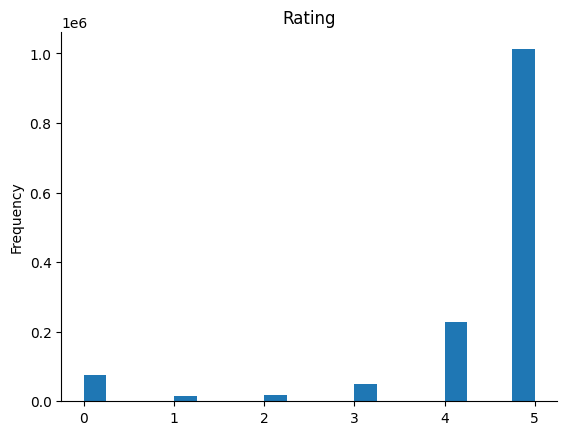

In [ ]:
from matplotlib import pyplot as plt
food_data['Rating'].plot(kind='hist', bins=20, title='Rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

Let's take now only the ones that we need to construct our network.

In [19]:
net_data = food_data[['RecipeId', 'Name', 'RecipeCategory', 'AggregatedRating','Calories']].dropna(subset=('AggregatedRating','RecipeCategory','Calories')).drop_duplicates(subset=('RecipeId'))
net_data

,RecipeId,Name,RecipeCategory,AggregatedRating,Calories
0,38,Low-Fat Berry Blue Frozen Dessert,Frozen Desserts,4.5,170.9
4,39,Biryani,Chicken Breast,3.0,1110.7
5,40,Best Lemonade,Beverages,4.5,311.1
14,41,Carina's Tofu-Vegetable Kebabs,Soy/Tofu,4.5,536.1
16,42,Cabbage Soup,Vegetable,4.5,103.6
...,...,...,...,...,...
1401957,540876,Backyard Breakfast Egg Salad,Breakfast,5.0,179.7
1401958,540899,Butter Pecan Banana Muffins,Breads,5.0,232.3
1401960,541030,Everything but the Bagel Seasoning (Trader Joe...,< 15 Mins,5.0,222.4
1401961,541195,The Most Refreshing Lemonade,Beverages,5.0,177.4


In [20]:
sample_fraction = 0.01
data = net_data.sample(frac=sample_fraction, random_state=42)

Each unique RecipeId is a node in our network.

Each edge comes from the difference between calories of two nodes. If this difference is below the fixed threshold it means the pair of nodes is connected.

## Creating the graph

After having uploaded the datasets and defined its nodes and links we are going to visualize and create the network.

In [17]:
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/graph.pkl"
infile = open(DATA_PATH,'rb')
graph = pickle.load(infile)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualization

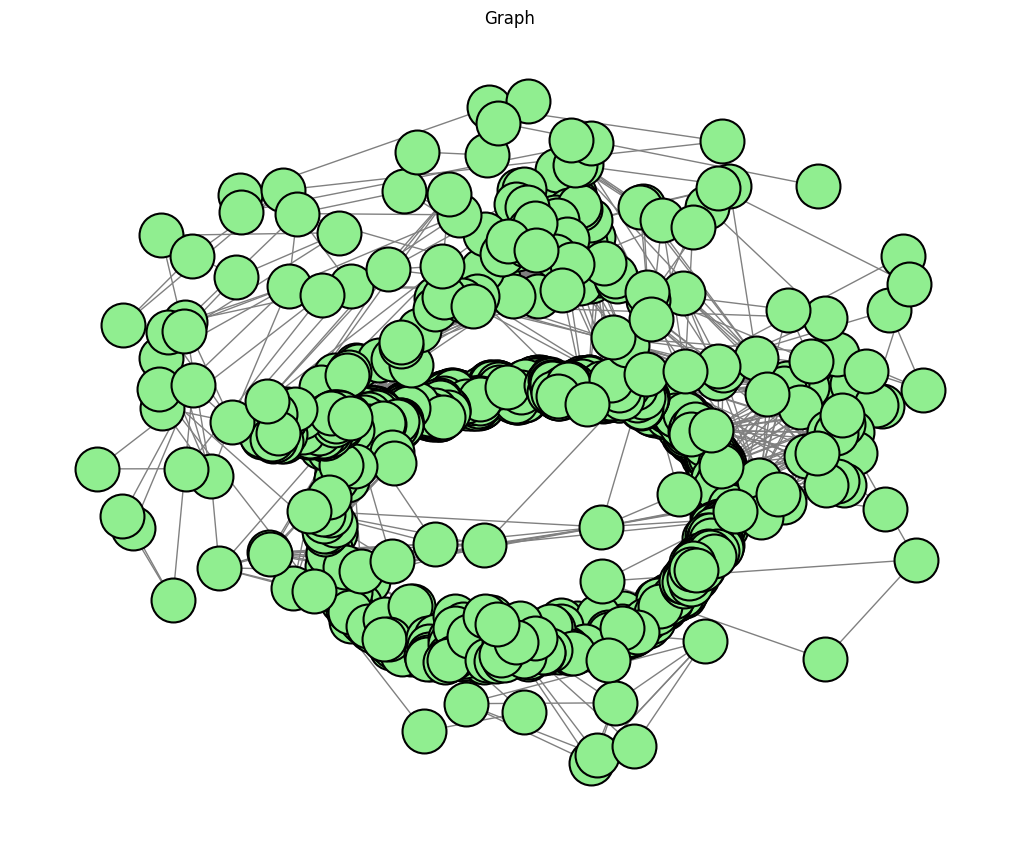

In [ ]:
pos = nx.spring_layout(graph, k=0.50, iterations=50)

plt.figure(figsize=(10, 8))
nx.draw(graph, pos, node_size=1000, node_color='lightgreen', edge_color='gray', font_size=10, node_shape='o', linewidths=1.5, edgecolors='black')
plt.title("Graph")
plt.show()

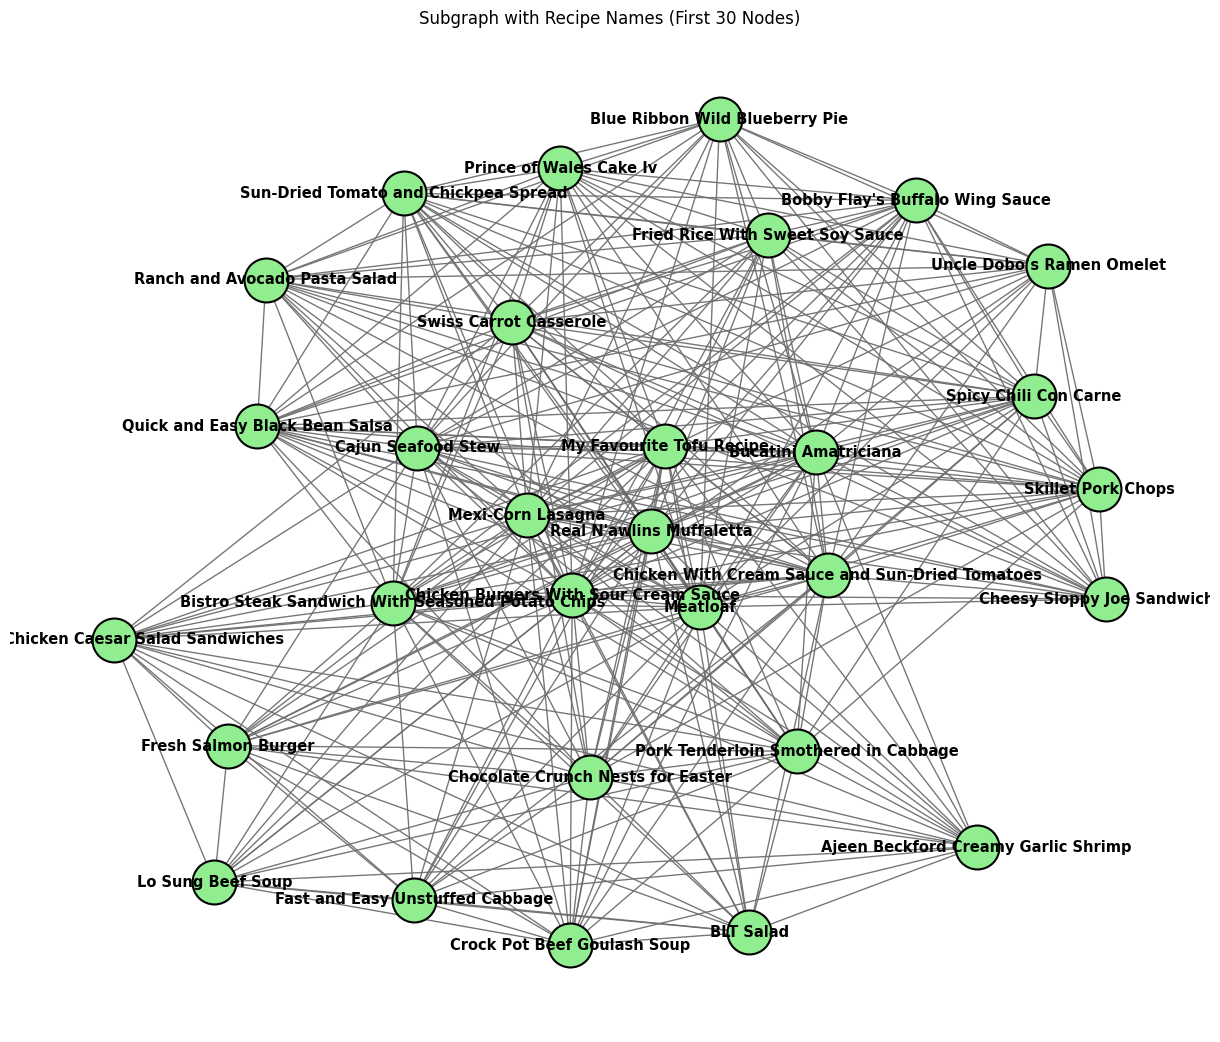

In [ ]:
selected_nodes = list(graph.nodes())[:30]
subgraph = graph.subgraph(selected_nodes)
pos = nx.spring_layout(subgraph, k=0.50, iterations=50)
node_labels = {node: data.loc[data['RecipeId'] == node, 'Name'].values[0] for node in subgraph.nodes()}

plt.figure(figsize=(12, 10))
nx.draw(subgraph, pos, with_labels=True, labels=node_labels, node_size=1000, font_size=10.5, font_color='black', font_weight='bold',
        node_color='lightgreen', edge_color='gray', node_shape='o', linewidths=1.5, edgecolors='black')

nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.1)

plt.title("Subgraph with Recipe Names (First 30 Nodes)")
plt.show()

## Graph creation

In [ ]:
graph = nx.Graph()

In [ ]:
calorie_threshold = 50

In [ ]:
for recipe1, recipe2 in itertools.combinations(data['RecipeId'], 2):
   # Get the calorie values and names for the current pair of recipes
    recipe1_info = data.loc[data['RecipeId'] == recipe1]
    recipe2_info = data.loc[data['RecipeId'] == recipe2]

    calories1 = recipe1_info['Calories'].values[0]
    calories2 = recipe2_info['Calories'].values[0]

    name1 = recipe1_info['Name'].values[0]
    name2 = recipe2_info['Name'].values[0]

    # Calculate the absolute difference in calories
    calorie_difference = abs(calories1 - calories2)

    # Check if the calorie difference is below the threshold
    if calorie_difference <= calorie_threshold:
        # Add nodes to the graph with recipe names as attributes
        graph.add_node(recipe1, name=name1)
        graph.add_node(recipe2, name=name2)

        # Add edge between recipes with the calorie difference as the weight
        graph.add_edge(recipe1, recipe2, weight=calorie_difference)

print(graph)

##Network Statistics

In [ ]:
num_nodes = len(graph.nodes())
num_edges = len(graph.edges())

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 2642
Number of edges: 441766


In [ ]:
degree = graph.degree()
degree_list = list(dict(degree).values())

In [ ]:
print("Min Degree:\t{}".format(np.min(degree_list)))
print("Max Degree:\t{}".format(np.max(degree_list)))
print("Mean Degree:\t{:.2f}".format(np.mean(degree_list)))
print("Standard Dev:\t{:.2f}".format(np.std(degree_list)))
print("Median Degree:\t{:.0f}".format(np.median(degree_list)))

Min Degree:	1
Max Degree:	539
Mean Degree:	334.42
Standard Dev:	164.94
Median Degree:	380


In [ ]:
density = nx.density(graph)
density

0.12662546961514418

Visualizing ECDF Linear and Log scale

Text(0.5, 1.0, 'ECDF plot - Linear scale')

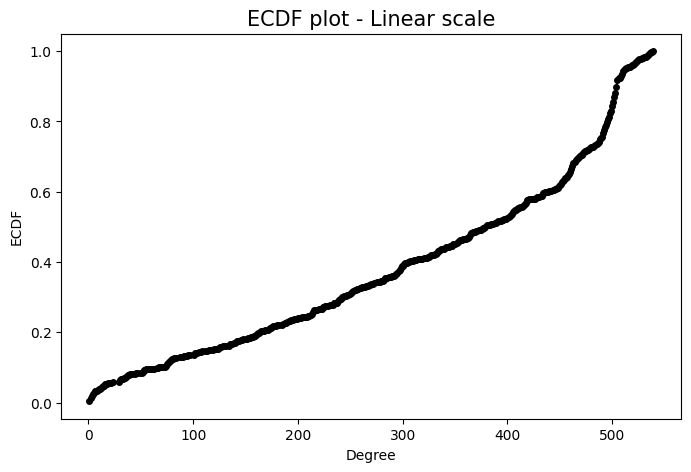

In [ ]:
cdf_function = ECDF(degree_list)
x = np.unique(degree_list)
y = cdf_function(x)

fig_cdf_function = plt.figure(figsize=(8,5))
axes = fig_cdf_function.gca()
axes.plot(x, y, color = 'black', linestyle = '--', marker = 'o',ms = 4)
axes.set_xlabel('Degree', size = 10)
axes.set_ylabel('ECDF', size = 10)
axes.set_title("ECDF plot - Linear scale", size=15)

Text(0.5, 1.0, 'ECDF plot - Log scale')

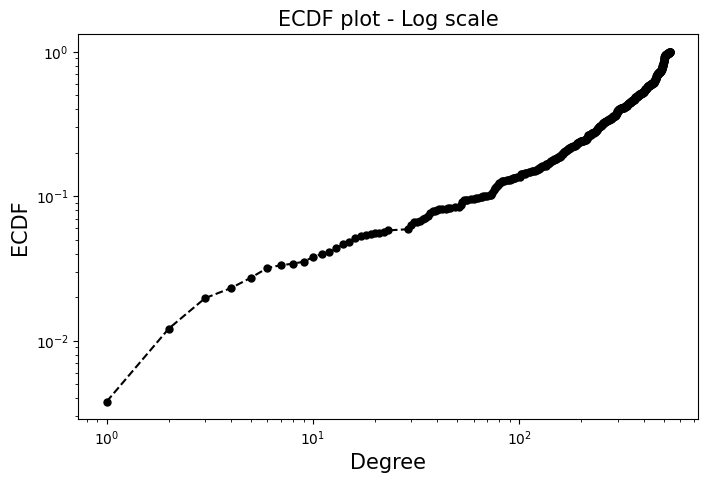

In [ ]:
fig_cdf_function = plt.figure(figsize=(8,5))
axes = fig_cdf_function.gca()
axes.loglog(x, y, color = 'black', linestyle = '--', marker = 'o',ms = 5)
axes.set_xlabel('Degree', size = 15)
axes.set_ylabel('ECDF', size = 15)
axes.set_title("ECDF plot - Log scale", size=15)

ECCDF

Text(0.5, 1.0, 'ECCDF - Log scale')

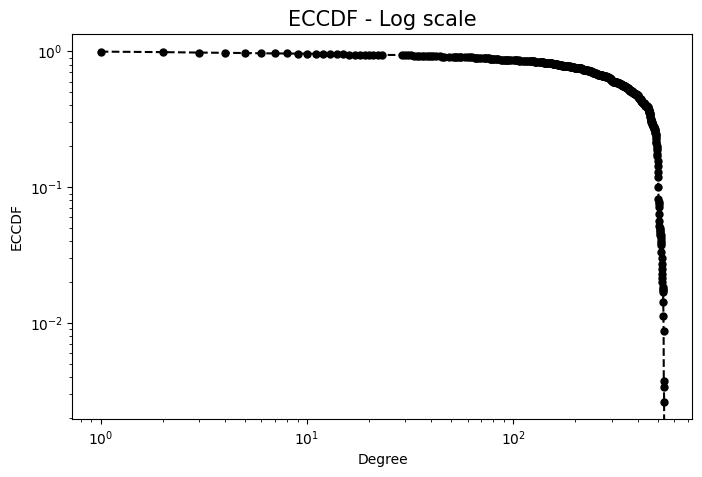

In [ ]:
y = 1-cdf_function(x)
fig_ccdf_function = plt.figure(figsize=(8,5))
axes = fig_ccdf_function.gca()
axes.loglog(x, y, color = 'black', linestyle = '--', marker = 'o',ms = 5)
axes.set_xlabel('Degree', size = 10)
axes.set_ylabel('ECCDF', size = 10)
axes.set_title("ECCDF - Log scale", size = 15)

##Comparison with a Random Network

In [ ]:
random_graph = nx.fast_gnp_random_graph(graph.order(),density)

print('Number of nodes:\t{}'.format(random_graph.order()))
print('Number of links:\t{}'.format(random_graph.size()))
random_degree_list = list(dict(random_graph.degree()).values())

Number of nodes:	2642
Number of links:	440973


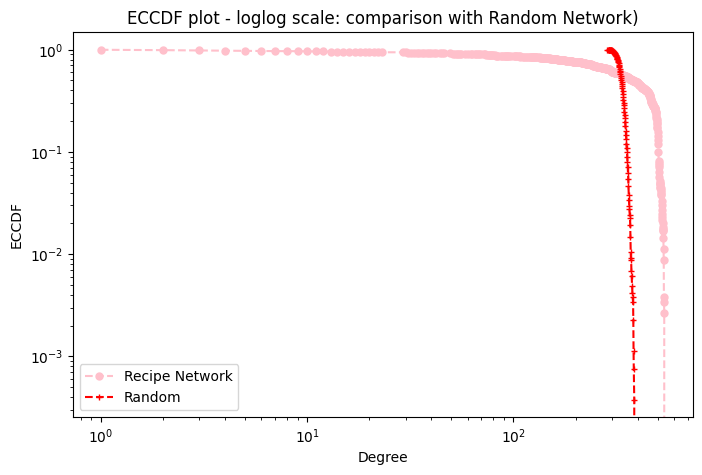

In [ ]:
cdf_function = ECDF(degree_list)
x = np.unique(degree_list)
y = cdf_function(x)

cdf_random = ECDF(random_degree_list)
x_random = np.unique(random_degree_list)
y_random = cdf_random(x_random)

fig_cdf_function = plt.figure(figsize=(8, 5))
axes = fig_cdf_function.gca()
axes.set_xscale('log')
axes.set_yscale('log')
axes.loglog(x, 1-y, color='pink', marker='o', ms=5, linestyle='--')
axes.plot(x_random, 1-y_random, color='red', marker='+', ms=5, linestyle='--')
axes.set_xlabel('Degree', size=10)
axes.set_ylabel('ECCDF', size=10)
axes.legend(['Recipe Network', 'Random'])
axes.set_title("ECCDF plot - loglog scale: comparison with Random Network)")

plt.savefig('plot.png')

plt.show()

### Centrality

In [ ]:
# degree centrality
degree_centrality = nx.degree_centrality(graph)
d_central = max(degree_centrality,key=degree_centrality.get)
max_degree_recipe_name = data.loc[data['RecipeId'] == d_central, 'Name'].values[0]

print("Name of the recipe with highest degree centrality:", max_degree_recipe_name)
print("Node with highest degree centrality:", d_central)


Name of the recipe with highest degree centrality: lemon lime chicken
Node with highest degree centrality: 63170


In [ ]:
# betweenness centrailty
bet_centrality = nx.betweenness_centrality(graph)
b_central = max(bet_centrality,key=bet_centrality.get)
max_b_recipe_name = data.loc[data['RecipeId'] == b_central, 'Name'].values[0]

print("Name of the recipe with highest betweenness centrality:", max_b_recipe_name)
print("Node with highest degree centrality:", b_central)


Name of the recipe with highest betweenness centrality: BBQ Pork Fried Rice
Node with highest degree centrality: 400635


In [ ]:
# closeness centrality
closeness_centrality = nx.closeness_centrality(graph)
c_central = max(closeness_centrality,key=closeness_centrality.get)
max_c_recipe_name = data.loc[data['RecipeId'] == c_central, 'Name'].values[0]

print("Name of the recipe with highest degree centrality:", max_c_recipe_name)
print("Node with highest degree centrality:", c_central)


Name of the recipe with highest degree centrality: Carrots a La Creme
Node with highest degree centrality: 146161


In [ ]:
# eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(graph)
e_central = max(eigenvector_centrality,key=eigenvector_centrality.get)
max_e_recipe_name = data.loc[data['RecipeId'] == e_central, 'Name'].values[0]

print("Name of the recipe with highest degree centrality:", max_e_recipe_name)
print("Node with highest degree centrality:", e_central)


Name of the recipe with highest degree centrality: Blueberry Ice Cream (For Ice Cream Machine)
Node with highest degree centrality: 242842


The pearson correlation is useful to check if the distribution of centralities is similar with different centrality measure.

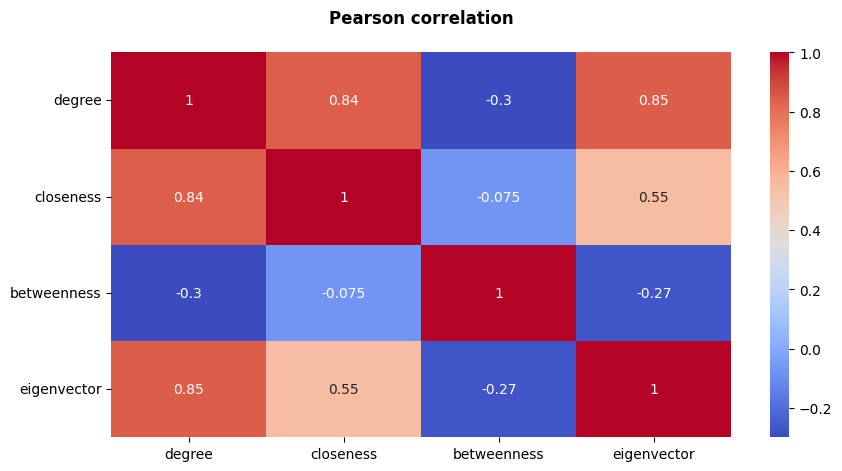

In [ ]:
all_centr = [degree_centrality, closeness_centrality, bet_centrality, eigenvector_centrality]
corrs = [[scipy.stats.pearsonr(list(c1.values()), list(c2.values()))[0] for c1 in all_centr] for c2 in all_centr]
centralities = ['degree', 'closeness','betweenness','eigenvector']

plt.figure(figsize = (10,5))
sns.heatmap(pd.DataFrame(corrs),annot = True,cmap = 'coolwarm')
plt.xticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.yticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.title('Pearson correlation\n', weight = 'bold')
plt.show()


### Top 5 hubs

In [ ]:
sorted_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)

print("Top 5 hubs in the network for degree centrality:")
for i in range(5):
    node_id = sorted_nodes[i]
    recipe_name = data.loc[data['RecipeId'] == node_id, 'Name'].values[0]
    print("Node:", node_id, "| Recipe Name:", recipe_name)

Top 5 hubs in the network:
Node: 63170 | Recipe Name: lemon lime chicken
Node: 242842 | Recipe Name: Blueberry Ice Cream (For Ice Cream Machine)
Node: 466936 | Recipe Name: Sweet Potato Gratin With Pecan-Crumb Topping
Node: 175102 | Recipe Name: Warm Sour Apple and Buttermilk Torte
Node: 239796 | Recipe Name: Eileen's Jelly Meatballs


In [ ]:
sorted_nodes = sorted(bet_centrality, key=bet_centrality.get, reverse=True)

print("Top 5 hubs in the network for betweenness centrality:")
for i in range(5):
    node_id = sorted_nodes[i]
    recipe_name = data.loc[data['RecipeId'] == node_id, 'Name'].values[0]
    print("Node:", node_id, "| Recipe Name:", recipe_name)

Top 5 hubs in the network:
Node: 400635 | Recipe Name: BBQ Pork Fried Rice
Node: 67683 | Recipe Name: Strawberry Jam
Node: 47547 | Recipe Name: Chicken Enchilada Pie
Node: 21425 | Recipe Name: Chocolate Chocolate Chip Cookies
Node: 233021 | Recipe Name: Colorado Grilled Cheese Sandwiches


In [ ]:
sorted_nodes = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)

print("Top 5 hubs in the network for closeness centrality:")
for i in range(5):
    node_id = sorted_nodes[i]
    recipe_name = data.loc[data['RecipeId'] == node_id, 'Name'].values[0]
    print("Node:", node_id, "| Recipe Name:", recipe_name)

Top 5 hubs in the network:
Node: 146161 | Recipe Name: Carrots a La Creme
Node: 205139 | Recipe Name: Brown and Wild Rice With Asparagus
Node: 24339 | Recipe Name: Turkey Stuffed Bell Peppers
Node: 93228 | Recipe Name: Double Chocolate Snack Cake #2
Node: 90678 | Recipe Name: Coronation Chicken to Die For.


In [ ]:
sorted_nodes = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)

print("Top 5 hubs in the network for eigenvector centrality:")
for i in range(5):
    node_id = sorted_nodes[i]
    recipe_name = data.loc[data['RecipeId'] == node_id, 'Name'].values[0]
    print("Node:", node_id, "| Recipe Name:", recipe_name)

Top 5 hubs in the network:
Node: 242842 | Recipe Name: Blueberry Ice Cream (For Ice Cream Machine)
Node: 175102 | Recipe Name: Warm Sour Apple and Buttermilk Torte
Node: 239796 | Recipe Name: Eileen's Jelly Meatballs
Node: 106188 | Recipe Name: Thai Style Warm Chicken Salad With Chilli, Mint & Lime
Node: 163181 | Recipe Name: Orange Biscuits


### Connectivity

In [18]:
nx.is_connected(graph)

False

In [19]:
cc = nx.number_connected_components(graph)
print(cc)

17


In [22]:
[len(c) for c in nx.connected_components(graph)]

[2564, 15, 12, 7, 4, 6, 3, 3, 2, 5, 3, 3, 3, 4, 4, 2, 2]

In [31]:
lcc = max(nx.connected_components(graph), key = len)

In [ ]:
lcc_graph = graph.subgraph(lcc)
num_nodes_largest = len(lcc_graph.nodes())
num_edges_largest = len(lcc_graph.edges())
print("Number of nodes in the largest connected component:", num_nodes_largest)
print("Number of edges in the largest connected component:", num_edges_largest)

Number of nodes in the largest connected component: 2564
Number of edges in the largest connected component: 441641


In [ ]:
diameter = nx.diameter(lcc_graph)
print("Diameter:", diameter)

Diameter: 36


In [ ]:
clustering_coefficient = nx.average_clustering(graph)

print("Average clustering coefficient:", clustering_coefficient)

Average clustering coefficient: 0.7588485719863189


In [ ]:
transitivity = nx.transitivity(graph)
print("Global clustering coefficient:", transitivity)

Global clustering coefficient: 0.7561576650007287


Let us look inside one of the components to see which recipes are in there

In [35]:
fourth_component = list(nx.connected_components(graph))[3]

print("Recipes in the fourth connected component:")
for node in fourth_component:
    recipe_name = data[data['RecipeId'] == node]['Name'].values[0]
    print(recipe_name)

Recipes in the fourth connected component:
No Crust Coconut Pie
Brown Nut Bread
Mongolian Beef
Worcestershire Aioli Dip
Big Bob Gibson's Alabama White Barbecue Sauce
Creamy Eggnog
Chocolate Chip Cream Cheese Bars


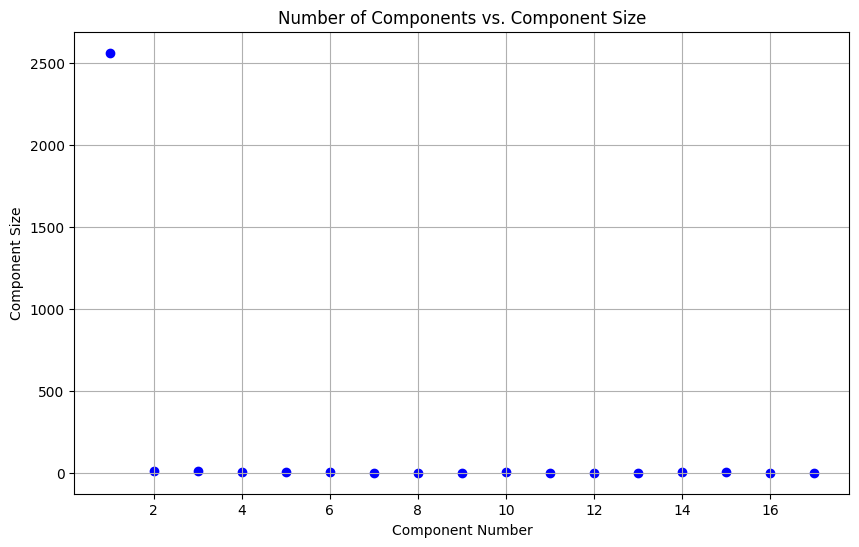

In [21]:
components = list(nx.connected_components(graph))

# Get the number of components and the size of each component
num_components = len(components)
component_sizes = [len(component) for component in components]

# Plot the number of components against the component size
plt.figure(figsize=(10, 6))
plt.scatter(range(1, num_components + 1), component_sizes, color='blue', marker='o')
plt.xlabel('Component Number')
plt.ylabel('Component Size')
plt.title('Number of Components vs. Component Size')
plt.grid(True)
plt.show()

What is the range of calories in the largest connected component?

In [32]:
lcc_data = data[data['RecipeId'].isin(lcc)]

# Extract the range of calories for the recipes in the largest connected component
min_calories = lcc_data['Calories'].min()
max_calories = lcc_data['Calories'].max()

print(f"Range of calories in the largest connected component: {min_calories} to {max_calories}")

Range of calories in the largest connected component: 0.0 to 1670.4


###Assortativity

In [ ]:
nx.degree_assortativity_coefficient(graph)

0.9371592286024997

In [ ]:
nx.has_bridges(graph)

True

In [ ]:
bridges = list(nx.bridges(graph))
print(f"Number of bridges: {len(bridges)}")

Number of bridges: 10


## Community detection

In [25]:
partitions = louvain.best_partition(graph)

<ipython-input-26-70702320ccb8>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(graph, pos, node_size=400, node_color=list(partitions.values()), cmap=plt.cm.get_cmap('viridis'), edge_color='gray', font_size=10)


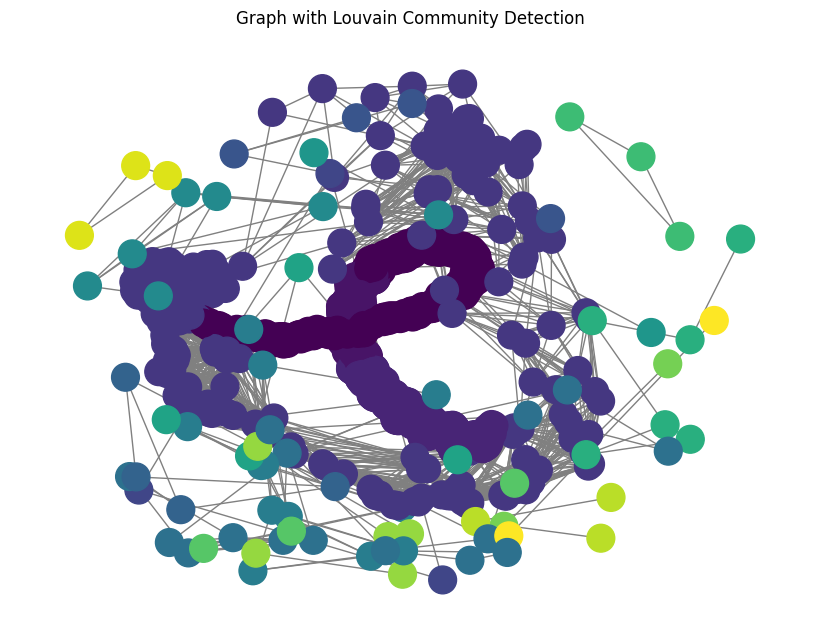

In [ ]:
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(graph, k = 0.50)
nx.draw(graph, pos, node_size=400, node_color=list(partitions.values()), cmap=plt.cm.get_cmap('viridis'), edge_color='gray', font_size=10)
plt.title("Graph with Louvain Community Detection")
plt.show()

In [26]:
num_communities = len(set(partitions.values()))
print("Number of communities:", num_communities)

modularity = louvain.modularity(partitions, graph)
print("Modularity of the partition:", modularity)

Number of communities: 21
Modularity of the partition: 0.5162303082085858


In [27]:
for community_id in range(num_communities):
    community_recipes = [data[data['RecipeId'] == recipe_id]['Name'].values[0] for recipe_id, community_label in partitions.items() if community_label == community_id]
    print(f"Community {community_id}: {community_recipes}")
    num_recipes = len(community_recipes)
    print(f"Community {community_id}: {num_recipes} recipes")

Community 0: ['Meatloaf', 'Fresh Salmon Burger', 'Sun-Dried Tomato and Chickpea Spread', 'Bistro Steak Sandwich With Seasoned Potato Chips', "Real N'awlins Muffaletta", 'Chicken With Cream Sauce and Sun-Dried Tomatoes', 'Fried Rice With Sweet Soy Sauce', 'Chicken Burgers With Sour Cream Sauce', 'Cajun Seafood Stew', 'Quick and Easy Black Bean Salsa', 'Bucatini Amatriciana', 'Fast and Easy Unstuffed Cabbage', 'Pork Tenderloin Smothered in Cabbage', 'Lo Sung Beef Soup', 'Spicy Chili Con Carne', 'Swiss Carrot Casserole', 'Chocolate Crunch Nests for Easter', 'Skillet Pork Chops', 'BLT Salad', 'Grilled Chicken Caesar Salad Sandwiches', 'Mexi-Corn Lasagna', 'Ajeen Beckford Creamy Garlic Shrimp', 'My Favourite Tofu Recipe', 'Crock Pot Beef Goulash Soup', "Bobby Flay's Buffalo Wing Sauce", "Mamma Caye's Green Spinach Enchiladas With Cilantro Cream Sauce", 'Salsa Burgers - Clean Eating', 'Sour Cream Lemon Pie', "Lisa's off the Hook White Chicken Chilli", 'Ranch Pasta Salad With Bacon', 'Cream C

Let us look inside a community and discover which recipes lie in there...

In [30]:
community_id = 4
community_recipes = [data[data['RecipeId'] == recipe_id]['Name'].values[0] for recipe_id, community_label in partitions.items() if community_label == community_id]
print(f"Recipes in Community {community_id}: ")
for recipe_name in community_recipes:
    print(recipe_name)

Recipes in Community 4: 
Angel Pillows
Applesauce Bread
Easy Peezy Pizza Dough (Bread Machine Pizza Dough)


What do these recipes have in common?

In [29]:
recipes_of_interest = ['Angel Pillows', 'Applesauce Bread', 'Easy Peezy Pizza Dough (Bread Machine Pizza Dough)']

# Filter the data to include only the rows corresponding to the recipes of interest
fil = data[data['Name'].isin(recipes_of_interest)]

calories_of_interest = fil[['Name', 'Calories', 'RecipeCategory']]
print(calories_of_interest)

                                                     Name  Calories  \
156486                                      Angel Pillows    1730.5   
575528                                   Applesauce Bread    1733.1   
272890  Easy Peezy Pizza Dough (Bread Machine Pizza Do...    1727.2   

       RecipeCategory  
156486   Drop Cookies  
575528   Yeast Breads  
272890  One Dish Meal  


## RecSys with Node2Vec

Let us build a recommendation system in order to find recipes that are similar to a specific one.

In [ ]:
node2vec = Node2Vec(graph, dimensions=64, walk_length=20, num_walks=200, p=2, q=5, workers=1)

Computing transition probabilities:   0%|          | 0/2642 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [07:06<00:00,  2.13s/it]


In [ ]:
# train the model on biased rw with a window of 10 (5 nodes before, 5 nodes after):
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [ ]:
def recommend(recipe_name):
    # Get the RecipeId for the given recipe name
    recipe_id = str(data[data['Name'] == recipe_name]['RecipeId'].values[0])

    # Find similar recipes based on the given recipe
    for id in model.wv.most_similar(recipe_id)[:3]:
        # Retrieve the title of the similar recipe
        similar_recipe_name = data[data['RecipeId'] == int(id[0])]['Name'].values[0]

        # Print the title of the similar recipe and its similarity score
        print(f'{similar_recipe_name}: {id[1]:.2f}')

In [ ]:
recommend("Bucatini Amatriciana")

Grilled Chicken Kisses: 0.97
There's a Party in My Tummy Red Beans and Rice: 0.97
Skip and Go Barefoot: 0.97


In [ ]:
recommend("Strawberry Pie")

Apple Brown Betty: 0.99
Garfield's Lasagna: 0.98
Hot Skillet Pizza: 0.98
